In [60]:
import pandas as pd

In [61]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
# appName= "hive_pyspark"
# master= "local"
import matplotlib.pyplot as plt
from textblob import TextBlob

import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from pyspark.sql.functions import udf,col, lower
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.mllib.tree import RandomForestModel, RandomForest
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [4]:
import os
import nltk

In [ ]:
df = pd.read_csv("df_sentiment.csv")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:
def convert_to_hour(val):
    try:
        return datetime.strptime(val, '%Y-%m-%d %H:%M:%S').strftime("%H")
    except:
        return np.nan

def convert_to_day(val):
    try:
        return datetime.strptime(val, '%Y-%m-%d %H:%M:%S').strftime("%d")
    except:
        return np.nan

In [8]:
df['created_day'] = df['created_at'].apply(lambda x: convert_to_day(x))

In [9]:
df['created_hour'] = df['created_at'].apply(lambda x: convert_to_hour(x))

In [18]:
series = df[df['created_day'].isin(['15', '16'])]['created_at'].apply(lambda x: convert_to_hour(x)).reset_index()

In [19]:
hours = series['created_at'].value_counts().reset_index().sort_values(by=['index'])

In [20]:
hours = hours.rename(columns={"index": "hour", 'created_at': 'accumulated number of posts'})

[Text(0.5, 1.0, 'Average number of tweets per hour')]

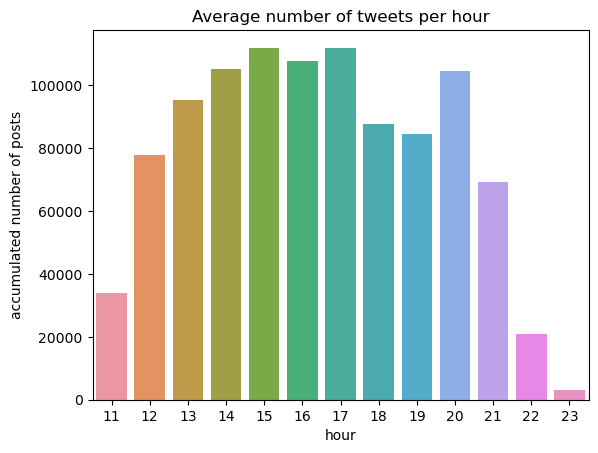

In [21]:
sns.barplot(data=hours, x='hour', y='accumulated number of posts').set(title="Average number of tweets per hour")

In [83]:
df.groupby('created_hour')['sentiment'].mean().reset_index()

,created_hour,sentiment
0,10,0.109444
1,11,0.062325
2,12,0.057655
3,13,0.062442
4,14,0.061052
5,15,0.058779
6,16,0.048434
7,17,0.051019
8,18,0.062736
9,19,0.046726


[Text(0.5, 1.0, 'Mean sentiment analysis per hour')]

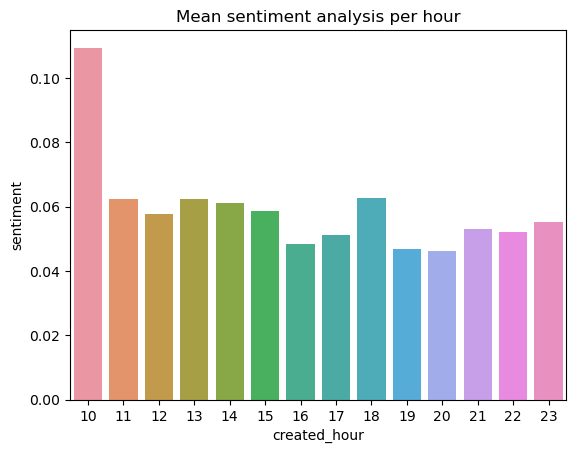

In [22]:
sns.barplot(data=df.groupby('created_hour')['sentiment'].mean().reset_index(), x='created_hour', y='sentiment').set(title='Mean sentiment analysis per hour')

In [108]:
df.dropna().sort_values(by=['sentiment']).head()['text'].iloc[0]

'@duty2warn He has retreated to his evil lair in a volcano.'

In [ ]:
import nltk
nltk.download([
     "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ])

In [62]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [63]:
def sentiment_analysis(sentence):
    scores = sia.polarity_scores(sentence)
    return scores['pos'] - scores['neg']

In [ ]:
df['score_new'] = df['text'].apply(lambda x: sentiment_analysis(x))

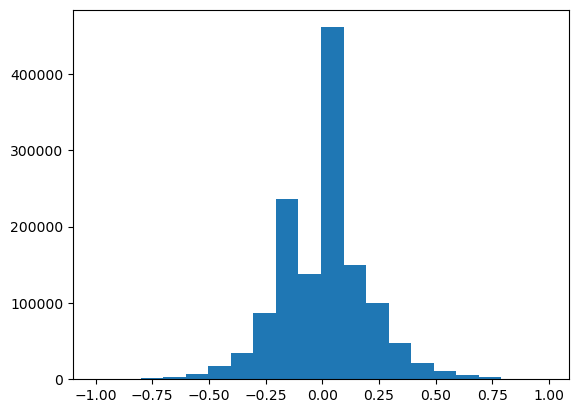

In [70]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
myHist = plt.hist(df['score_new'], bins=20)
plt.show()

In [18]:
df.dropna().sort_values(by=['score_new']).head()

,id,text,created_at,source,sentiment,created_day,created_hour,score_new
201122,1603816249477169174,Greedy Freak,2022-12-16 18:16:05,twitter,0.0,16,18,-1.000
186321,1603813662208143361,bitch,2022-12-16 18:05:49,twitter,0.0,16,18,-1.000
1278941,1603020740441378817,LOSER LOSER LOSER LOSER https://t.co/hkjOoTArsp,2022-12-14 13:35:01,twitter,0.0,14,13,-0.943
284950,1603849554880827418,Fuck fuck fuck Musk fuck,2022-12-16 20:28:26,twitter,-0.4,16,20,-0.933
739480,1603038801001070592,@Mollyploofkins BAD BAD BAD!!!,2022-12-14 14:46:47,twitter,-0.8,14,14,-0.931


[Text(0.5, 1.0, 'Mean sentiment analysis per hour')]

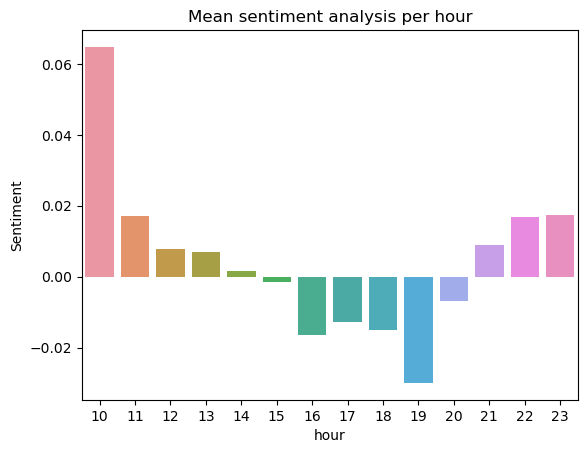

In [21]:
sns.barplot(data=df.groupby('created_hour')['score_new'].mean().reset_index().rename(columns={'score_new': 'Sentiment', 'created_hour': 'hour'}), x='hour', y='Sentiment').set(title='Mean sentiment analysis per hour')

In [88]:
df[df['text'].str.contains("musk")].dropna().sort_values(by=['score_new'])['text'].iloc[-1000:-960]

479984                  @MattWallace888 @elonmusk Let's? LOL
269116     @ForeverEversley @elonmusk @IFNY2775 @micsolan...
1100622    @kenklippenstein Commitment to free speech elo...
539304        @TomFitton @CNN @elonmusk @Twitter OUTSTANDING
886246     @elonmusk We need freedom! Forever 🙏🏻\nThanks ...
245554     @svgjz @elonmusk So all you care about is like...
312280     @elonmusk Freedom of crashing Tesla good job b...
305677     @JXakc @Unknowndhwhi @elonmusk Welcome aboard ...
304383         @elonmusk Thank you God and thank you Mr Musk
35845      @elonmusk Babara Streisand ist great! Yes, Mus...
912070     @Richard34213778 @DerekLacus @donie @elonmusk ...
640188     @Nerdyg10 @Tesla @elonmusk I do appreciate you...
680381     @NEWSMAX @elonmusk Great job!! It’s great to h...
1155554    @EvasTeslaSPlaid @elonmusk I wish South Dakota...
953725        @Tesla @elonmusk Congratulations Tesla team!!!
807525     @MuskUniversity @elonmusk Yes but all's well t...
1249506                 

In [43]:
sentences = df[df['sentiment'] > 0]['text'].sample(100000).to_list()

In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
tokenizer = RegexpTokenizer(r'\w+')

In [45]:
sentences = [word.lower() for sentence_ in sentences for word in tokenizer.tokenize(sentence_) if word not in stopwords.words('english')]

In [46]:
freqdst = FreqDist(sentences).most_common(100)

In [55]:
allowed_words = ['owned', 'musk', 'elon', 'twitter', 'elonmusk', 'bans', 'right', 'journalists', 'people', 'better', 'accounts', 'good']

In [56]:
freqdst_dct = dict(freqdst)
freqdst_dct = {key: value for key, value in freqdst_dct.items() if key in allowed_words}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'musk'),
  Text(1, 0, 'elon'),
  Text(2, 0, 'twitter'),
  Text(3, 0, 'elonmusk'),
  Text(4, 0, 'right'),
  Text(5, 0, 'people'),
  Text(6, 0, 'journalists'),
  Text(7, 0, 'accounts'),
  Text(8, 0, 'good'),
  Text(9, 0, 'owned'),
  Text(10, 0, 'better')])

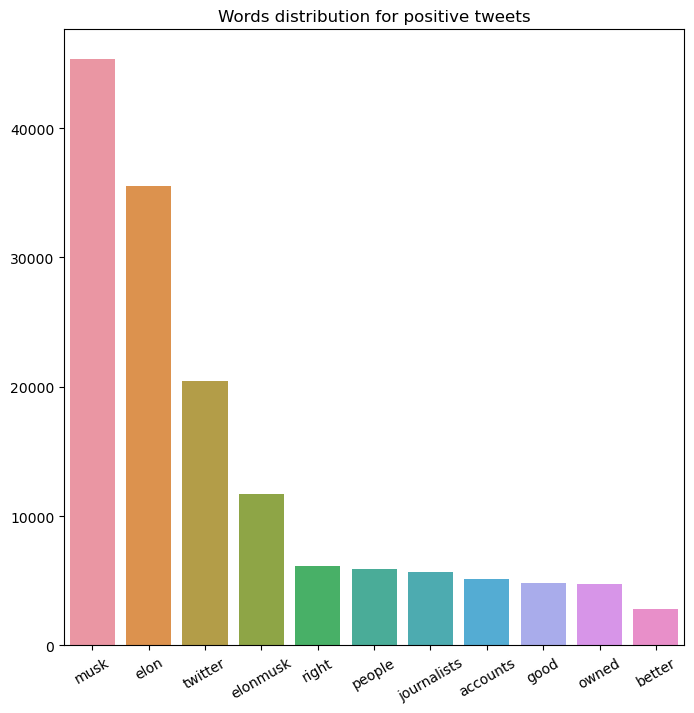

In [59]:
all_fdist = pd.Series(freqdst_dct)

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(8, 8))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax).set(title="Words distribution for positive tweets")
plt.xticks(rotation=30)

In [ ]:
df['datetime'] = pd.to_datetime(df['created_at'])
grouped = df.groupby(pd.Grouper(key='datetime', axis=0, freq='T')).count()